In [1]:
# Importo librerias
# Data analysis and data wrangling
import pandas as pd
import numpy as np
import missingno as msno

# Regex para imputar valores
import re

# Librerias graficas.
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Filtrar outliers.
from scipy import stats

# Machine Learning models.
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
# Deep Learning
from tensorflow import keras
from tensorflow.keras import layers

# Integrate Keras a Scikit-Learn
from scikeras.wrappers import KerasRegressor

# Data preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# Cross Validation
from sklearn.model_selection import KFold, cross_val_score

# Hiperparameter tunning.
from sklearn.model_selection import GridSearchCV

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif

# Metricas
from sklearn.metrics import r2_score

# exportar modelos entrenados
import pickle
import os

## Preparando el DataFrame.

Importo el dataset y realizo los joins necesarios para poder unificar los distitos DF's.

OBS: tuve que cambiar el tipo de archivo (de xlsx a xls) ya que me daba errores de permisos.

In [2]:
# Importo Datos
# Leo los datos de Inputs_1
df_description = pd.read_excel('data/Dataset_Inmuebles_read.xls', sheet_name='Inputs_1')
# Reasigno el numero de index.
df_description.index = df_description['ID'].values
# Dropeo la columna ID.
df_description.drop(columns='ID', inplace=True)

# Leo los datos de Inputs_2.
df_price = pd.read_excel('data/Dataset_Inmuebles_read.xls', sheet_name='Inputs_2')
# Reasigno el numero de index.
df_price.index = df_price['ID'].values
# Dropeo la columna ID.
df_price.drop(columns='ID', inplace=True)

# Leo los datos de Inputs_3.
df_barrio = pd.read_excel('data/Dataset_Inmuebles_read.xls', sheet_name='Inputs_3')
# Reasigno el numero de index.
df_barrio.index = df_barrio['ID'].values
# Dropeo la columna ID.
df_barrio.drop(columns='ID', inplace=True)

In [3]:
# Voy a ver la cantidad de registros que tiene cada dataset.
print('df_description tiene %s filas, %s columnas' %(df_description.shape[0], df_description.shape[1]))
df_description.head(3)

df_description tiene 10567 filas, 5 columnas


,property_type,lat,lon,description,title
5415,apartment,-346.115.808,-584.101.838,Departamento de 2 ambientes superficie total 5...,Venta Departamento 2 ambientes 52m2 cochera Ap...
1761,apartment,-345.904.453,-58.410.856.200.000.000,Piso de 4 ambientes con dependencia y balcón a...,Guemes y C.Díaz - Piso de 4 c/dependencia en v...
1826,apartment,-345.829.338.033,-584.219.018.513,Living comedor.Dormitorios 1 con placard. Coci...,Venta. Departamento 2 Ambientes. Guemes 4400. ...


In [4]:
#
print('df_price tiene %s filas, %s columnas' %(df_price.shape[0], df_price.shape[1]))
df_price.head(3)

df_price tiene 10567 filas, 6 columnas


,price_usd,surface_total,surface_covered,floor,rooms,expenses
222,250.0k,150,140,NaN,6,NaN
4224,399.0k,164,155,NaN,4,NaN
318,130.5k,52,47,NaN,2,NaN


In [5]:
#
print('df_barrio tiene %s filas, %s columnas' %(df_barrio.shape[0], df_barrio.shape[1]))
df_barrio.head(3)

df_barrio tiene 10567 filas, 2 columnas


,barrio,comuna
4630,NUÑEZ,13
10134,MATADEROS,9
1371,PALERMO,14


Ahora voy a proceder a unir todos los dataframes para unificar la informacion.

In [6]:
# Procedo a unir los DF's
data_join_1 = df_description.merge(df_price, left_index=True, right_index=True)
data = data_join_1.merge(df_barrio, left_index=True, right_index=True)

# Reordeno el dataframe.
data = data[['lat', 'lon', 'barrio', 'comuna', 'property_type', 'rooms', \
            'floor', 'surface_covered', 'surface_total', 'expenses', \
            'price_usd', 'title', 'description'
]]
print('El DataFrame final tiene %s filas, %s columnas' %(data.shape[0], data.shape[1]))
data.head(3)

El DataFrame final tiene 10567 filas, 13 columnas


,lat,lon,barrio,comuna,property_type,rooms,floor,surface_covered,surface_total,expenses,price_usd,title,description
5415,-346.115.808,-584.101.838,BALVANERA,3,apartment,2,NaN,44,52,NaN,100.0k,Venta Departamento 2 ambientes 52m2 cochera Ap...,Departamento de 2 ambientes superficie total 5...
1761,-345.904.453,-58.410.856.200.000.000,PALERMO,14,apartment,4,NaN,104,111,5000.0,350.0k,Guemes y C.Díaz - Piso de 4 c/dependencia en v...,Piso de 4 ambientes con dependencia y balcón a...
1826,-345.829.338.033,-584.219.018.513,PALERMO,14,apartment,2,NaN,32,32,NaN,93.5k,Venta. Departamento 2 Ambientes. Guemes 4400. ...,Living comedor.Dormitorios 1 con placard. Coci...


## Analizo los nulos.

Ahora que tengo toda la información unificada voy a ver la cantidad de nulos con las que cuenta este dataset.

In [7]:
# Cantidad de nulos.
data.isnull().sum()

lat                   0
lon                   0
barrio                0
comuna                0
property_type       488
rooms                 0
floor              8850
surface_covered       0
surface_total         0
expenses           8032
price_usd             0
title                 0
description           0
dtype: int64

In [8]:
# Proporcion de nulos.
data.isnull().sum() / data.shape[0]

lat                0.000000
lon                0.000000
barrio             0.000000
comuna             0.000000
property_type      0.046182
rooms              0.000000
floor              0.837513
surface_covered    0.000000
surface_total      0.000000
expenses           0.760102
price_usd          0.000000
title              0.000000
description        0.000000
dtype: float64

<AxesSubplot: >

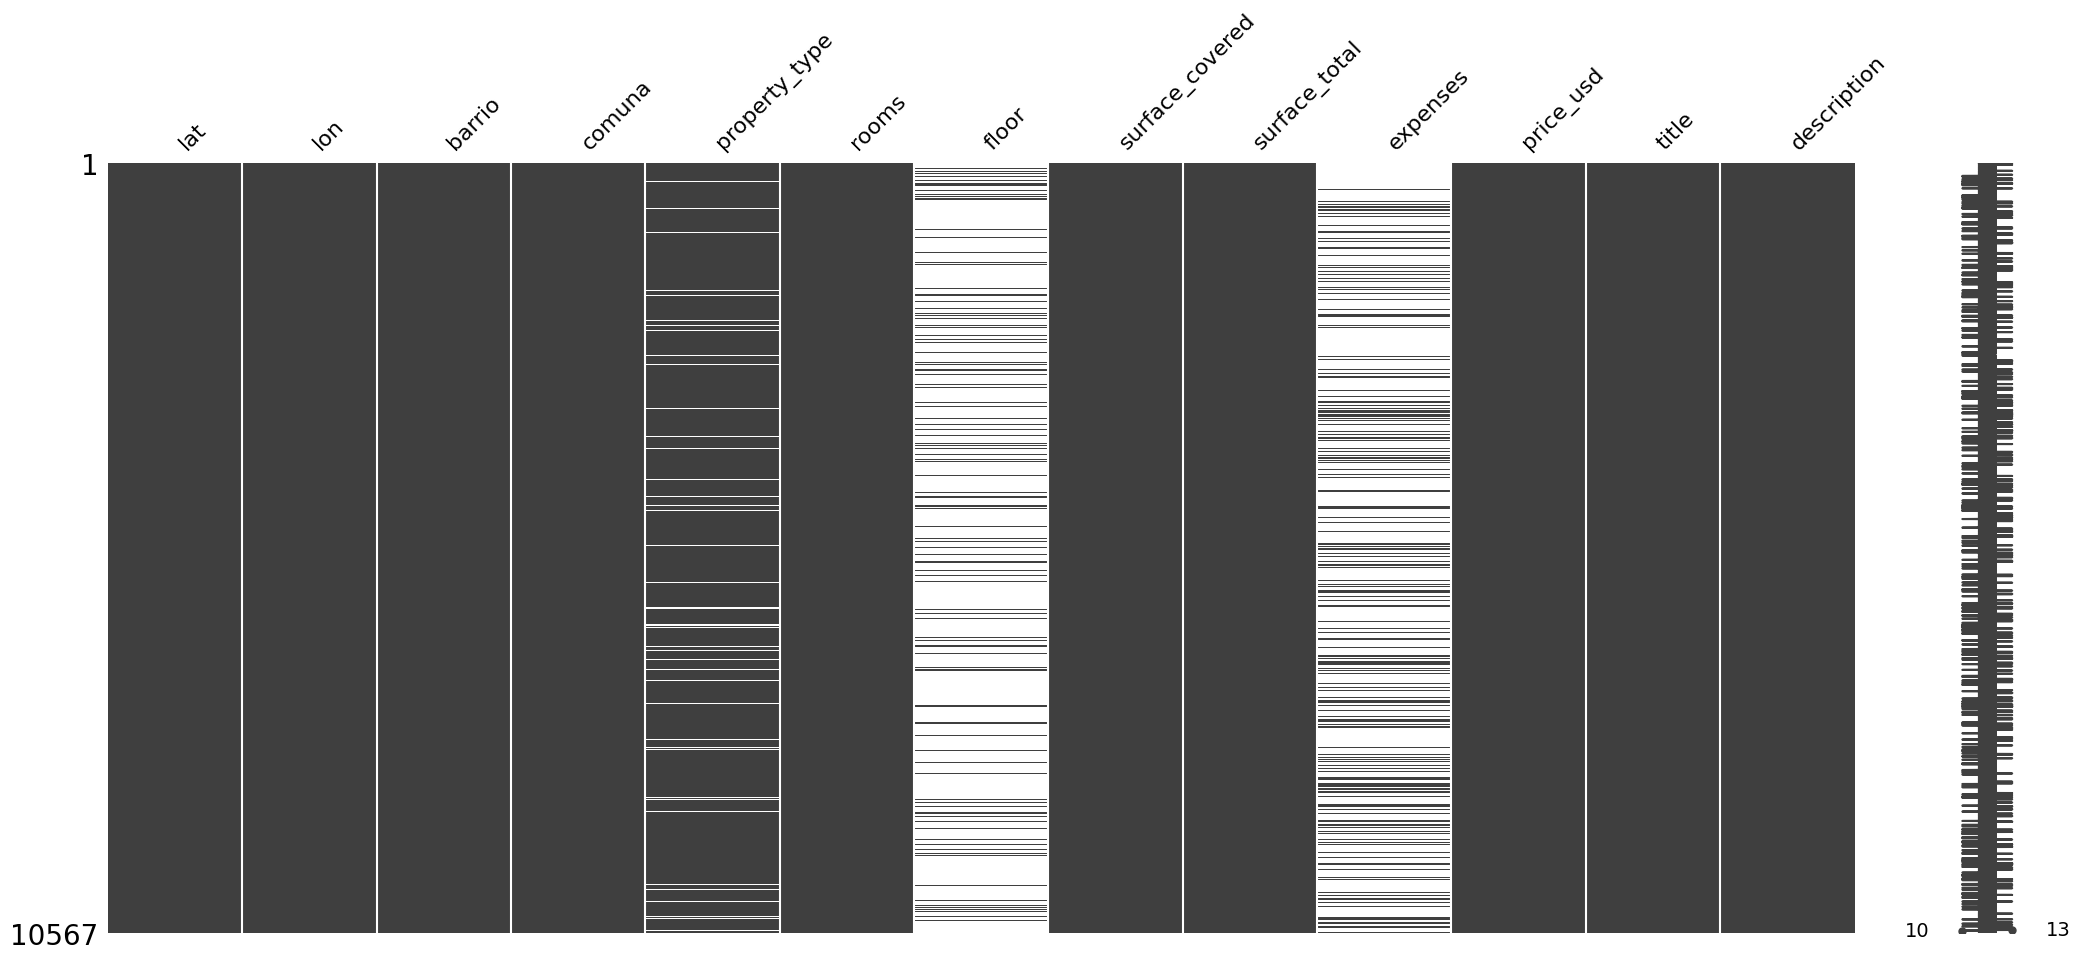

In [9]:
msno.matrix(data)

Se puede ver que hay una alta presencia de nulos en la columnas 'floor' y 'expenses'.

Tambien hay nulos en el tipo de propiedad pero no en gran cantidad.

Ambas columnas tienen un alto porcentaje de nulos, al imputar los valores podria estar generando errores no deseados, ya que al imputar no estamos dandole un valor verdadero sino un valor obtenido mediante regex o alguna imputacion que considere oportuna (media agrupada, media de la columna, imputacion con algun modelo de machine learning, etc).

Voy a proceder a imputar los valores de estas columnas, y al final comparare los modelos ganadores al incluir o no estas columnas para ver si su imputacion trajo beneficios o no.

## Duplicados

Primero voy a ver si hay filas duplicadas, y eliminare las filas duplicadas.

In [10]:
print('El Data Frame tiene', data.duplicated().sum(), 'filas duplicadas')

El Data Frame tiene 2 filas duplicadas


In [11]:
# Procedo a eliminar las filas duplicadas y me quedo con el primer registro.
data.drop_duplicates(keep='first', inplace=True)

## Data Wrangling.

Ahora procedere a convertir y mapear los datos de la columna target, ya que los mismos tienen los decimales expresados con la letra k. 

Utilizo regex para mapear los valores.

In [12]:
# Genero el patron de busqueda.
patron = '(\d{1,3}.?\d{0,3})k'
# Compilo el patron.
patron_re = re.compile(patron)

# Recorro cada fila y me quedo con los numberos.
num_serie_re = data['price_usd'].apply(lambda x: x if x is np.NaN else patron_re.search(x).group(1))
# Cambio el tipo de datos de object a float y luego multiplico por 1000 para obtener el valor numerico.
data['price_usd'] = num_serie_re.astype('float') * 1000
data['price_usd'].sample(5)

1002     485000.0
5873     280000.0
10202    142000.0
9804     140000.0
2854     162800.0
Name: price_usd, dtype: float64

## Imputacion.

#### Columna - 'property_type'

Voy a imputar los valores de dicha columna utilizando la columna 'title' donde pareciera que se dice que tipo de propiedad es.

Voy a utilizar la libreria regex para definir patrones de busqueda y asi imputar valores.

In [13]:
# Primero voy a ver que valores son posibles obtener.
data['property_type'].value_counts()

apartment    9309
house         768
Name: property_type, dtype: int64

In [14]:
# Creo un patron de busqueda.
patron = '(apartment|house|departamento|casa)'
# Compilo el patron de busqueda e ignoro mayusculas.
patron_re = re.compile(patron, flags=re.IGNORECASE)

# Para limitar la busqueda solo voy a buscar en los registros nulos.
mask = data['property_type'].isnull()

# Utilizo el metodo 'apply' para recorrer cada registro.
property_type_re = data.loc[mask, 'title'].apply(lambda x: x if x is np.NaN else patron_re.search(x).group(1))

# Imprimo la cantidad de elementos que se encontraron.
print('Elementos encontrados: %s' %(property_type_re.notnull().sum()))
# Veo como se encontraron los elementos.
property_type_re[property_type_re.notnull()].value_counts()

Elementos encontrados: 488


APARTMENT       224
Departamento    147
DEPARTAMENTO     75
departamento     11
Casa             11
CASA              9
casa              5
HOUSE             4
house             1
House             1
Name: title, dtype: int64

In [15]:
# Ahora voy a proceder a imputar esos valores.
# Voy a usar la mascara definida arriba, la cual selecciona los valores nulos.
data.loc[mask, 'property_type'] = property_type_re

# Ahora que estan imputados los valores tengo que mapear esos datos para que tengan los mismos nombres.
# Transformo en minusculas todos los registros.
data['property_type'] = data['property_type'].str.lower()

# Reemplazo los valores.
data['property_type'] = data['property_type'].replace({'departamento' : 'apartment', 'casa' : 'house'})

print('Cantidad de nulos: %s' %(data['property_type'].isnull().sum()))
data['property_type'].value_counts()

Cantidad de nulos: 0


apartment    9766
house         799
Name: property_type, dtype: int64

#### Columna - 'expenses'

Esta columna no la voy a imputar por regex ya que me va a traer bastantes problemas, en vez lo que voy a hacer es calcular una relacion entre las expensas y el precio de un inmueble.

La imputacion de esta columna la hare con la media de la variable 'price_usd' y agrupada segun la cantidad de ambientes, tengo el problema de que al haber outliers esas medias se pueden ver sesgadas y por ende realizar una imputacion erronea.

Por lo tanto la imputacion de esta columna la hare luego de que haya filtrado los outliers, ya que de lo contrario podria haber errores como el siguiente.

In [16]:
# Creo un dataset para imputar estos valores
df_expenses = data[['barrio','property_type','rooms','price_usd','expenses']].copy()
# Creo una columna para ver la proporcion entre el precio de un inmueble y sus expensas.
df_expenses['proporcion_expensas'] = np.round(df_expenses['expenses'] / df_expenses['price_usd'],3)

df_expenses[df_expenses['expenses'].notnull()].sample(3)

,barrio,property_type,rooms,price_usd,expenses,proporcion_expensas
845,BELGRANO,apartment,2,190000.0,1800.0,0.009
6384,FLORES,apartment,4,480000.0,5500.0,0.011
6308,FLORES,apartment,3,142500.0,1600.0,0.011


In [17]:
# Voy a fijarme que al dividir las expensas por el precio los valores tengan sentido, 
#   // ya que si hay precios = 0 o precios muy grandes con expensas iguales a 0 traera errores
df_expenses[df_expenses['proporcion_expensas'] ==float('inf')]

,barrio,property_type,rooms,price_usd,expenses,proporcion_expensas
2771,PALERMO,apartment,6,0.0,4.0,inf
1395,PALERMO,apartment,5,0.0,26000.0,inf
5162,PUERTO MADERO,apartment,3,0.0,20000.0,inf


Se puede ver que al haber precios de 0 dolares, la proporcion me da un valor float infinito. 

Podria haber otros errores de los cuales no me de cuenta y realizar una imputacion erronea.

#### Columna 'floor'.

Una manera de imputar esta columna seria con REGEX pero las descripciones estan sucias y obtener los valores mediante un patron lo mas probable es que me traiga algunos valores incompletos o errados (por mas completo que este el patron de busqueda), por ejemplo usar un patron para obtener la cantidad de pisos podria ser usar las palabras "piso/s" o "planta/s" y esto me podria traer las siguientes coincidencias "planta baja", "pisos de madera", etc.

En este caso se puede observar una distribucion y valores anormales para los pisos. 

Ya que tiene valores muy irregulares y sin sentido, voy a proceder a dropear esta columna.

In [18]:
print(data['floor'].value_counts().index)
fig = px.histogram(data, x='floor')
fig.show()

Float64Index([  2.0,   1.0,   3.0,   4.0,   5.0,   6.0,   7.0,   8.0,   9.0,
               11.0,  10.0,  13.0,  14.0,  12.0,  15.0,  16.0,  17.0,  21.0,
               25.0,  19.0,  18.0,  20.0,  24.0,  31.0, 104.0, 801.0, 112.0,
              103.0, 546.0,  22.0, 129.0,  30.0, 904.0, 609.0, 901.0, 111.0,
              502.0, 203.0, 302.0, 604.0,  23.0, 606.0, 121.0,  28.0,  39.0,
              242.0,  37.0, 403.0, 433.0, 210.0, 603.0, 304.0, 202.0, 245.0],
             dtype='float64')


## Seleccion de features para el modelo.

In [19]:
data_features = data[['barrio', 'property_type', 'rooms', 'surface_covered', 'surface_total', 'expenses','price_usd']]
data_features.head()

,barrio,property_type,rooms,surface_covered,surface_total,expenses,price_usd
5415,BALVANERA,apartment,2,44,52,NaN,100000.0
1761,PALERMO,apartment,4,104,111,5000.0,350000.0
1826,PALERMO,apartment,2,32,32,NaN,93500.0
3410,ALMAGRO,apartment,3,55,55,1733.0,140000.0
946,BELGRANO,apartment,4,185,185,NaN,690000.0


## Outliers.

Un outlier es una observacion que se encuentra anormalmente lejos de los valores normales en una distribucion, estos deben ser eliminados ya que afecta los resultados de los analisis.

Procedo a eliminar los outliers antes del data analisis ya que hay observaciones que son errores y no son producto de la naturaleza, como se puede ver en el grafico proximo.

In [20]:
# 
specs = [
    [{'type' : 'box'    }],
    [{'type' : 'scatter'}]
    ]
# Creo un DataFrame para plotear los valores de los departamentos.
data_apartment = data_features[data_features['property_type'] == 'apartment']

fig =  make_subplots(rows=2, cols=1, specs=specs, shared_xaxes=True, vertical_spacing=0.01, row_heights=[0.3, 0.7], subplot_titles=('Apartment surface distribution depending on rooms amount', ''))

tr1 = go.Box(x=data_apartment['surface_covered'], name='Covered Surface Apartment')

tr2 = go.Scatter(x=data_apartment['surface_covered'], y=data_apartment['rooms'], mode='markers')

fig.add_trace(tr1, row=1, col=1)
fig.add_trace(tr2, row=2, col=1)

fig.update_xaxes(title_text='Surface Covered', row=2)
fig.update_yaxes(title_text='Rooms', row=2)
fig.update_layout(height=600, width=1500, showlegend=False)
fig.show()

La limpieza de outliers lo voy a hacer mediante el rango intercuartilico (RIC) obteniendo los limites superior e inferior de lo que seria un Boxplot.

<center><img src='./img/boxplot.png' width=40% height = 40%></center>

Este grafico nos da una ideade la distribucion de los datos y nos permite indicar los cortes de los cuartiles, la mediana y permite visualizar los casos atipicos.

Los limites de la caja vienen dados por el primer cuartil (25%) y el tercer cuartil (75%). Sumando o restando estos cuartiles al RIC obtenemos los limites.

El rango intercuartilico es la diferencia entre los valores del tercer cuartil y el primer cuartil. Los bigotes son las lineas que se extienden por fuera de la caja, para definir su largo hay que multiplicar el RIC por 1.5, restando y sumando este valor a los quartiles obtenemos los limites infeior y superior.

Para filtrar los outliers voy a discriminar segun el tipo de propiedad, ya que un departamento tiene una distribucion totalemente distinta a la de una casa (en el caso de ambientes, superficies y precios).

Voy a crear una funcion para automatizar el proceso de eliminacion de outliers.

In [21]:
# Esta funcion va a filtrar los outliers de la columna que pertenece al Dataframe que se pasa como parametro.
# Toma como parametro:
#   // Un objeto dataframe con la totalidad de las columnas
#   // Nombre de la columna a filtrar como string.
def outliers_filter (data_fun, col):    
    # Obtengo el rango interquartilico, usando el metodo quantile obtengo los cuartiles para 75% y 25%.
    riq = data_fun[col].quantile(q=0.75) - data_fun[col].quantile(q=0.25)
    # Calculo los limites inferiores y superiores.
    upper_fence = data_fun[col].quantile(q=.75) + 1.5 * riq
    lower_fence = data_fun[col].quantile(q=.25) - 1.5 * riq
    
    # Creo una mascara para filtrar mis valores con esos limites.
    mask = (data_fun[col] >= lower_fence) & (data_fun[col] <= upper_fence)
    # Aplico mascaray filtro outliers.
    data_filtrado = data_fun[mask]
    
    # Elementos antes de filtrar.
    elementos_inicio = data_fun.shape[0]
    # Elementos despues de filtrar.
    elementos_final = data_filtrado.shape[0]
    
    print('Elementos eliminados %s' %(elementos_inicio - elementos_final))
    return data_filtrado

# Voy a difinir los dataframes a filtrar.
data_apartment = data_features[data_features['property_type'] == 'apartment']

data_house = data_features[data_features['property_type'] == 'house']

In [22]:
# Antes de aplicar la funcionde arriba voy a eliminar los registros que no tienen sentido.
data_apartment = data_apartment[data_apartment['price_usd']>0]
data_apartment = data_apartment[data_apartment['surface_total']>10]
data_apartment = data_apartment[data_apartment['surface_covered']>10]

# Aplico la funcion a cada una de mis columnas numericas
data_apartment = outliers_filter(data_apartment, 'price_usd')
data_apartment = outliers_filter(data_apartment, 'surface_total')
data_apartment = outliers_filter(data_apartment, 'surface_covered')
data_apartment = outliers_filter(data_apartment, 'rooms')

Elementos eliminados 722
Elementos eliminados 602
Elementos eliminados 241
Elementos eliminados 217


In [23]:
data_house = data_house[data_house['price_usd']>0]
data_house = data_house[data_house['surface_total']>10]
data_house = data_house[data_house['surface_covered']>10]

data_house = outliers_filter(data_house, 'price_usd')
data_house = outliers_filter(data_house, 'surface_total')
data_house = outliers_filter(data_house, 'surface_covered')
data_house = outliers_filter(data_house, 'rooms')

Elementos eliminados 25
Elementos eliminados 32
Elementos eliminados 15
Elementos eliminados 21


In [24]:
# Uno los dos DF.
print('Totalidad de elementos filtrados = %s' %(data_features.shape[0] - data_apartment.shape[0] - data_house.shape[0]))

data_features = pd.concat([data_apartment, data_house], axis=0, ignore_index=False).sort_index(ascending=True)
print('Shape del DF filtrado - %s Filas - %s Columnas' %(data_features.shape[0], data_features.shape[1]))
data_features.head(3)

Totalidad de elementos filtrados = 1924
Shape del DF filtrado - 8641 Filas - 7 Columnas


,barrio,property_type,rooms,surface_covered,surface_total,expenses,price_usd
0,MONSERRAT,apartment,2,56,56,NaN,119000.0
4,MONSERRAT,apartment,4,96,104,NaN,180000.0
5,MONSERRAT,apartment,4,94,104,NaN,255000.0


In [25]:
# Voy a fijarme que la superficie total no supere a la cubierta y si es asi lo invierto.
mask = data_features['surface_covered'] > data_features['surface_total']
data_features[mask]

,barrio,property_type,rooms,surface_covered,surface_total,expenses,price_usd


## Imputacion Columna 'expenses'.

Bien ahora que ya resolvi el tema de los outliers voy a imputar los valores de esta columna.

In [26]:
# Creo un dataset para imputar estos valores
df_expenses = data_features[['barrio','property_type','rooms','price_usd','expenses']].copy()
# Creo una columna para ver la proporcion entre el precio de un inmueble y sus expensas.
df_expenses['proporcion_expensas'] = np.round(df_expenses['expenses'] / df_expenses['price_usd'],3)
print(df_expenses.isnull().sum())
df_expenses[df_expenses['expenses'].notnull()].sample(3)

barrio                    0
property_type             0
rooms                     0
price_usd                 0
expenses               6560
proporcion_expensas    6560
dtype: int64


,barrio,property_type,rooms,price_usd,expenses,proporcion_expensas
8420,CABALLITO,apartment,3,174000.0,1852.0,0.011
4399,RECOLETA,apartment,3,100000.0,2100.0,0.021
2651,PALERMO,apartment,4,440000.0,9500.0,0.022


In [27]:
# Voy a fijarme que al dividir las expensas por el precio los valores tengan sentido, 
#   // ya que si hay precios = 0 o precios muy grandes con expensas iguales a 0 traera errores
df_expenses[df_expenses['proporcion_expensas'] ==float('inf')]

,barrio,property_type,rooms,price_usd,expenses,proporcion_expensas


In [28]:
# De este DataFrame puedo agrupar segun el barrio , tipo de propiedad y cantidad de ambientes
df_grouped = df_expenses.groupby(['barrio', 'property_type', 'rooms'])

# Voy a usar este agrupamiento para inputar los valores nulos de las expensas
#   // con el valor promedio de la proporcion entre el precio y las expensas 
#   // de un inmueble, segun donde esta ubicado y la cantidad de ambientes.
df_expenses['proporcion_expensas'] = df_expenses['proporcion_expensas'].fillna(df_grouped['proporcion_expensas'].transform('mean'))

# Ahora para imputar los valores de la columna 'expenses', 
#   // multiplico la proprcion de las expensas con el precio.
# Mascara para no pisar valores nulos.
mask = df_expenses['expenses'].isnull()
df_expenses.loc[mask, 'expenses'] = df_expenses['price_usd'] * df_expenses['proporcion_expensas'] 

df_expenses.isnull().sum()

barrio                   0
property_type            0
rooms                    0
price_usd                0
expenses               861
proporcion_expensas    861
dtype: int64

In [29]:
# En cuanto a los valores restantes, voy a realizar una segunda agrupacion
#   // pero segun el barrio y la cantidad de ambientes.
df_grouped = df_expenses.groupby(['barrio','rooms'])
df_expenses['proporcion_expensas'] = df_expenses['proporcion_expensas'].fillna(df_grouped['proporcion_expensas'].transform('mean'))

mask = df_expenses['expenses'].isnull()
df_expenses.loc[mask, 'expenses'] = df_expenses['price_usd'] * df_expenses['proporcion_expensas']

df_expenses.isnull().sum()

barrio                   0
property_type            0
rooms                    0
price_usd                0
expenses               523
proporcion_expensas    523
dtype: int64

In [30]:
# Ultima agrupacion en base a la cantidad de ambientes.
df_grouped = df_expenses.groupby(['rooms'])
df_expenses['proporcion_expensas'] = df_expenses['proporcion_expensas'].fillna(df_grouped['proporcion_expensas'].transform('mean'))

mask = df_expenses['expenses'].isnull()
df_expenses.loc[mask, 'expenses'] = df_expenses['price_usd'] * df_expenses['proporcion_expensas']
df_expenses.isnull().sum()

barrio                   0
property_type            0
rooms                    0
price_usd                0
expenses               155
proporcion_expensas    155
dtype: int64

In [31]:
# Para finalizar imputo por la media de la columna.
df_expenses['proporcion_expensas'] = df_expenses['proporcion_expensas'].fillna(df_expenses['proporcion_expensas'].mean())

mask = df_expenses['expenses'].isnull()
df_expenses.loc[mask, 'expenses'] = df_expenses['price_usd'] * df_expenses['proporcion_expensas']
df_expenses.isnull().sum()

barrio                 0
property_type          0
rooms                  0
price_usd              0
expenses               0
proporcion_expensas    0
dtype: int64

In [32]:
# procedo a imputar los valores del Dataset original
data_features['expenses'] = np.round(df_expenses['expenses'],2)
# Proporcion de nulos.
data_features.isnull().sum() / data.shape[0]

barrio             0.0
property_type      0.0
rooms              0.0
surface_covered    0.0
surface_total      0.0
expenses           0.0
price_usd          0.0
dtype: float64

In [33]:
# Filtro outliers de esta columna, procedo de misma manera.
# Voy a difinir los dataframes a filtrar.
data_apartment = data_features[data_features['property_type'] == 'apartment']

data_house = data_features[data_features['property_type'] == 'house']

data_apartment = data_apartment[data_apartment['expenses']>100]
# Aplico la funcion la columna expenses
data_apartment = outliers_filter(data_apartment, 'expenses')

data_house = data_house[data_house['expenses']>100]
# Aplico la funcion la columna expenses
data_house = outliers_filter(data_house, 'expenses')

Elementos eliminados 361
Elementos eliminados 13


In [34]:
# Uno los dos DF.
print('Totalidad de elementos filtrados = %s' %(data_features.shape[0] - data_apartment.shape[0] - data_house.shape[0]))

data_features = pd.concat([data_apartment, data_house], axis=0, ignore_index=False).sort_index(ascending=True)
print('Shape del DF filtrado - %s Filas - %s Columnas' %(data_features.shape[0], data_features.shape[1]))
data_features.head(3)

Totalidad de elementos filtrados = 388
Shape del DF filtrado - 8253 Filas - 7 Columnas


,barrio,property_type,rooms,surface_covered,surface_total,expenses,price_usd
0,MONSERRAT,apartment,2,56,56,2165.8,119000.0
4,MONSERRAT,apartment,4,96,104,2880.0,180000.0
5,MONSERRAT,apartment,4,94,104,4080.0,255000.0


## Data analysis.

Ahora voy a realizar un analisis de los datos para ver como se distribuyen y si logragramos ver alguna tendencia de como podria variar el precio de un inmueble.

In [35]:
# Distribucion de la variable precio.
specs = [
    [{'type' : 'box'      } , {'type' : 'box'}],
    [{'type' : 'histogram'} , {'type' : 'histogram'}]
    ]
fig =  make_subplots(rows=2, cols=2, specs=specs, shared_xaxes=True, vertical_spacing=0.01, row_heights=[0.3, 0.7], subplot_titles=('Apartment price distribution', 'House price distribution'))

tr1 = go.Histogram(x=data_apartment['price_usd'], name='Histograma Apartment')
tr2 = go.Box(x=data_apartment['price_usd'], name='Boxplot Apartment')

fig.add_trace(tr1, row=2, col=1)
fig.add_trace(tr2, row=1, col=1)

tr3 = go.Histogram(x=data_house['price_usd'], name='Histograma House')
tr4 = go.Box(x=data_house['price_usd'], name='Boxplot House')

fig.add_trace(tr3, row=2, col=2)
fig.add_trace(tr4, row=1, col=2)

fig.update_layout(title='Distribucion del precio segun el tipo de propiedad', height=600, width=1500, showlegend=False)
fig.show()

Puede observarser que los precios de los departamentos siguen una distribucion normal con asimetria a derecha.

Se observa una diferencia entre las distribuciones de las variables consideradas:

- El valor de los departamentos tiene una asimetria hacia la izquierda, lo que indica que en general los departamentos tienen un precio menor.

- El precio de las casas esta un poco mas centrada, se puede observar en el valor de la media en el boxplot, lo que indica que las casas manejan un precio mayor que los departamentos, lo cual tiene sentido.

In [36]:
# Distribucion de la variable surface_total.
specs = [
    [{'type' : 'box'      } , {'type' : 'box'}],
    [{'type' : 'histogram'} , {'type' : 'histogram'}]
    ]
fig =  make_subplots(rows=2, cols=2, specs=specs, shared_xaxes=True, vertical_spacing=0.01, row_heights=[0.3, 0.7], subplot_titles=('Apartment total surface distribution', 'House total surface distribution'))

tr1 = go.Histogram(x=data_apartment['surface_total'], name='Histograma Apartment')
tr2 = go.Box(x=data_apartment['surface_total'], name='Boxplot Apartment')

fig.add_trace(tr1, row=2, col=1)
fig.add_trace(tr2, row=1, col=1)

tr3 = go.Histogram(x=data_house['surface_total'], name='Histograma House')
tr4 = go.Box(x=data_house['surface_total'], name='Boxplot House')

fig.add_trace(tr3, row=2, col=2)
fig.add_trace(tr4, row=1, col=2)

fig.update_layout(title='Distribucion de la superficie total segun el tipo de propiedad', height=600, width=1500, showlegend=False)
fig.show()

In [37]:
# Distribucion de la variable surface_covered.
specs = [
    [{'type' : 'box'      } , {'type' : 'box'}],
    [{'type' : 'histogram'} , {'type' : 'histogram'}]
    ]
fig =  make_subplots(rows=2, cols=2, specs=specs, shared_xaxes=True, vertical_spacing=0.01, row_heights=[0.3, 0.7], subplot_titles=('Apartment covered surface distribution', 'House covered surface distribution'))

tr1 = go.Histogram(x=data_apartment['surface_covered'], name='Histograma Apartment')
tr2 = go.Box(x=data_apartment['surface_covered'], name='Boxplot Apartment')

fig.add_trace(tr1, row=2, col=1)
fig.add_trace(tr2, row=1, col=1)

tr3 = go.Histogram(x=data_house['surface_covered'], name='Histograma House')
tr4 = go.Box(x=data_house['surface_covered'], name='Boxplot House')

fig.add_trace(tr3, row=2, col=2)
fig.add_trace(tr4, row=1, col=2)

fig.update_layout(title='Distribucion de la superficie cubierta segun el tipo de propiedad', height=600, width=1500, showlegend=False)
fig.show()

In [38]:
# Distribucion de la variable surface_covered.
specs = [
    [{'type' : 'box'      } , {'type' : 'box'}],
    [{'type' : 'histogram'} , {'type' : 'histogram'}]
    ]
fig =  make_subplots(rows=2, cols=2, specs=specs, shared_xaxes=True, vertical_spacing=0.01, row_heights=[0.3, 0.7], subplot_titles=('Apartment expenses distribution', 'House expenses distribution'))

tr1 = go.Histogram(x=data_apartment['expenses'], name='Histograma Apartment')
tr2 = go.Box(x=data_apartment['expenses'], name='Boxplot Apartment')

fig.add_trace(tr1, row=2, col=1)
fig.add_trace(tr2, row=1, col=1)

tr3 = go.Histogram(x=data_house['expenses'], name='Histograma House')
tr4 = go.Box(x=data_house['expenses'], name='Boxplot House')

fig.add_trace(tr3, row=2, col=2)
fig.add_trace(tr4, row=1, col=2)

fig.update_layout(title='Distribucion de expenses segun el tipo de propiedad', height=600, width=1500, showlegend=False)
fig.show()

Aca se puede observar que la imputacion que realice tiene sentido, luego de filtrar los outliers puede verse como esta variable sigue una distribucion normal, igual a la variable de precio, lo cual tiene sentido ya que esa variable fue la principal para imputar estos valores.

In [39]:
# Ahora voy a ver como varia el precio del inmueble en funcion del tipo de propiedad y de la superficie total.
specs = [[{'type' : 'scatter'}], [{'type' : 'scatter'}]]

fig =  make_subplots(rows=2, cols=1, specs=specs, shared_xaxes=True, subplot_titles=('Apartment distribution', 'House price distribution'))

tr1 = go.Scatter(x=data_apartment['price_usd'], y=data_apartment['surface_total'], mode='markers')
tr2 = go.Scatter(x=data_house['price_usd'],     y=data_house['surface_total'], mode='markers')

fig.add_trace(tr1, row=1, col=1)
fig.add_trace(tr2, row=2, col=1)

fig.update_xaxes(title_text='Precio del inmueble', row=2, col=1)
fig.update_yaxes(title_text='m2 totales')
fig.update_layout(title='precio de un inmueble en funcion de los m2 totales', height=600, width=1500, showlegend=False)
fig.show()

Aca se puede apreciar una tendencia lineal de subida, a medida que aumentan los m2 totales se puede ver como aumenta el precio, lo que tiene bastante sentido.

Ademas se puede ver una diferencia entre el precio por m2 totales entre los departamentos y las casas. Departamentos con menos m2 que las casas cuestan lo mismo que casas con mayor m2 totales.

In [40]:
# Veo como se distribuye los m2 cubiertos en funcion de la cantidad de ambientes.
specs = [[{'type' : 'scatter'}], [{'type' : 'scatter'}]]

fig =  make_subplots(rows=2, cols=1, specs=specs, shared_xaxes=True, subplot_titles=('Apartment distribution', 'House price distribution'))

tr1 = go.Scatter(x=data_apartment['surface_covered'], y=data_apartment['rooms'], mode='markers')
tr2 = go.Scatter(x=data_house['surface_covered'],     y=data_house['rooms'], mode='markers')

fig.add_trace(tr1, row=1, col=1)
fig.add_trace(tr2, row=2, col=1)

fig.update_xaxes(title_text='Superficie cubierta', row=2, col=1)
fig.update_yaxes(title_text='Ambientes')
fig.update_layout(title='m2 cubiertos en funcion de la cantidad de ambientes', height=600, width=1500, showlegend=False)
fig.show()

Aqui puede observarse una relacion lineal, a medida que aumentan los ambientes aumenta la superficie cubierta, ademas puede verse que las casas cuentan en general con una mayor cantidad de superficie cubierta (ambas cosas tienen sentido).

In [41]:
# Distribucion de los ambientes segun el tipo de propiedad.
data_plot = data_features.groupby(['property_type', 'rooms']).size()

specs = [[{'type' : 'domain'}, {'type' : 'domain'}]]

fig =  make_subplots(rows=1, cols=2, specs=specs, subplot_titles=('Apartment distribution', 'House price distribution'))

tr1 = go.Pie(labels= data_plot['apartment'].index, values= data_plot['apartment'].values)
tr2 = go.Pie(labels= data_plot['house'].index, values= data_plot['house'].values)

fig.add_trace(tr1, row=1, col=1)
fig.add_trace(tr2, row=1, col=2)

fig.update_xaxes(title_text='Superficie total', row=2, col=1)
fig.update_yaxes(title_text='Superficie cubierta')
fig.update_layout(title='Ambientes segun el tipo de propiedad', height=600, width=1500)
fig.show()

La mayoria de los departamentos son de 2 y 3 ambientes, las casas de 4 y 5 ambientes.

In [42]:
# Cantidad de propiedades segun el barrio.
data_plot = data_features.groupby(['property_type', 'barrio']).size()

specs = [
    [{'type' : 'domain'}    , {'type' : 'domain'}],
    [{'type' : 'histogram'} , {'type' : 'histogram'}]
]

fig =  make_subplots(rows=2, cols=2, specs=specs, vertical_spacing=0.01, row_heights=[0.7, 0.3], subplot_titles=('Apartment distribution', 'House price distribution'))

tr1 = go.Pie(labels= data_plot['apartment'].index, values= data_plot['apartment'].values)
tr2 = go.Pie(labels= data_plot['house'].index, values= data_plot['house'].values)

fig.add_trace(tr1, row=1, col=1)
fig.add_trace(tr2, row=1, col=2)

data_plot = data_features.groupby(['property_type', 'barrio']).size().reset_index()

data_plot_apartment = data_plot[data_plot['property_type']=='apartment'].sort_values(by=0, ascending=False)
data_plot_house = data_plot[data_plot['property_type']=='house'].sort_values(by=0, ascending=False)

tr3 = go.Bar(x=data_plot_apartment['barrio'], y=data_plot_apartment[0], name='Apartment distribution')
tr4 = go.Bar(x=data_plot_house['barrio'], y=data_plot_apartment[0], name='House distribution')

fig.add_trace(tr3, row=2, col=1)
fig.add_trace(tr4, row=2, col=2)

fig.update_layout(title='Cantidad de determinado inmueble segun el barrio',height=1000, width=1500)
fig.show()

Vemos aqui la distribucion de los tipos de propiedad segun el barrio, puede verse que los barrios que mayor cantidad de departamentos tienen es palermo y recoleta.

Villa Devoto y Flores son los barrios donde mayor proporcion de casas hay.

In [43]:
# Me fijo el precio promedio por propiedad dependiendo del tipo de barrio.
data_plot = data_features.groupby(['property_type', 'barrio'])['price_usd'].mean().reset_index().sort_values('price_usd', ascending=False)
fig = px.bar(data_plot, x='price_usd', y='barrio', facet_col='property_type', text_auto='.2s')
fig.update_layout(title='Precio promedio de una propiedad segun su tipo y su barrio', height=1100, width=1500)
fig.show()

Aca se puede ver que las casas mas caras se encuentran en San Telmo, mientras que los departamentos mas caros se ubican en Puerto Madero. 

Ademas se puede ver un contraste entre la diferencia de precios entre una casa y un departamento ubicado en el mismo barrio.

## Correlaciones

Voy a ver ahora como se correlacionan las distintas variables

In [44]:
fig = px.imshow(data_features.corr(), text_auto=True)
fig.update_layout(title='Correlacion de las distintas variables', height=500, width=800)
fig.show()

C:\Users\juanb\AppData\Local\Temp\ipykernel_3560\2801491310.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Aca podemos ver que la correlacion de la variable target con todas las variables continuas es bastante fuerte, lo que indicaria que un modelo lineal performara bien.

Ademas se puede ver que todas las correlaciones son positivas lo que indica que las variables tienen una relacion lineal positiva con la variable target.

## Preparacion del dataset para modelado.

Antes de proceder al modelado voy a preparar el dataset. dividiendo los datos en datos de entrenamiento y en datos de testeo, luego voy a binarizar las variables categoricas y escalar las features continuas.

In [45]:
# Primero declaro las features.
X = data_features.drop(columns=['price_usd'])
# y la variable target.
y = data_features['price_usd']

# Luego separo en datos de entrenamiento y en datos de testeo.
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=10)

# Ademas voy a definir mis variables categoricas y mis variables numericas.
cat_cols = ['barrio', 'property_type']
num_cols = ['rooms', 'surface_covered', 'surface_total', 'expenses']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6189, 6), (2064, 6), (6189,), (2064,))

In [46]:
# Para que pandas no me tire un mensaje de warning.
pd.options.mode.chained_assignment = None

In [47]:
# Ahora voy a Dumificar las variables categoricas.
# Instancio OneHotEncoder.
enc = OneHotEncoder(drop='first')
# Fiteo y transformo mis datos de train.
train_enc_array = enc.fit_transform(X_train[cat_cols]).toarray()
# Creo un DataFrame con las variables dummificadas.
one_hot_cat_train = pd.DataFrame(data=train_enc_array, columns=enc.get_feature_names_out(), index=X_train.index)

# Ahora voy a unir las variables dummificadas con las variables numericas.
# Dropeo variables categoricas del DF de train.
X_train.drop(columns=cat_cols, inplace=True)
# Concateno los DF's.
X_train = pd.concat([X_train, one_hot_cat_train], axis=1)
print(X_train.shape)

(6189, 52)


In [48]:
# Transformo los datos de test.
test_enc_array = enc.transform(X_test[cat_cols]).toarray()
# Creo el DataFrame.
one_hot_cat_test = pd.DataFrame(data=test_enc_array, columns=enc.get_feature_names_out(), index=X_test.index)
one_hot_cat_test.head(2)

# Dropeo columnas en test.
X_test.drop(columns=cat_cols, inplace=True)
# Concateno los DF's.
X_test = pd.concat([X_test, one_hot_cat_test], axis=1)
print(X_test.shape)

(2064, 52)


In [49]:
# Procedo a escalar los variable numericas para que todos tengan la misma escala.
# Instancio escalador.
sc = StandardScaler()
# Creo una copia del dataframe.
X_train_sc = X_train.copy()
# Fiteo y transformo los datos de train.
X_train_sc[num_cols] = sc.fit_transform(X_train[num_cols])


X_test_sc = X_test.copy()
# Transformo los datos de test.
X_test_sc[num_cols] = sc.transform(X_test[num_cols])

In [50]:
X_train_sc.head(2)

,rooms,surface_covered,surface_total,expenses,barrio_ALMAGRO,barrio_BALVANERA,barrio_BARRACAS,barrio_BELGRANO,barrio_BOCA,barrio_BOEDO,...,barrio_VILLA LUGANO,barrio_VILLA LURO,barrio_VILLA ORTUZAR,barrio_VILLA PUEYRREDON,barrio_VILLA REAL,barrio_VILLA RIACHUELO,barrio_VILLA SANTA RITA,barrio_VILLA SOLDATI,barrio_VILLA URQUIZA,property_type_house
37,1.232480,0.245099,1.035549,0.107407,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5932,-1.296917,-0.678548,-0.699281,-1.015916,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
X_test_sc.head(2)

,rooms,surface_covered,surface_total,expenses,barrio_ALMAGRO,barrio_BALVANERA,barrio_BARRACAS,barrio_BELGRANO,barrio_BOCA,barrio_BOEDO,...,barrio_VILLA LUGANO,barrio_VILLA LURO,barrio_VILLA ORTUZAR,barrio_VILLA PUEYRREDON,barrio_VILLA REAL,barrio_VILLA RIACHUELO,barrio_VILLA SANTA RITA,barrio_VILLA SOLDATI,barrio_VILLA URQUIZA,property_type_house
8911,-0.453785,-0.616972,-0.582513,-0.239321,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7522,-0.453785,-0.473294,-0.365660,-0.412124,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modelado.

Ahora voy a plantear distintos modelos para ver cual es el que performara mejor de todos con los hiperparametros por defecto. Los modelos a plantear seran:

- Regresion Lineal
- Regresion Lasso
- Regression Ridge
- Random Forest
- Extra Trees
- AdaBoost
- XGBoost
- Una Red Neuronal simple.

Tanto Lasso como Ridge son sensibles a outliers por lo tanto emplearemos Robustscaler(https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html), este metodo usa estadisticos que son mas robustos a los outliers que Standarscaler. 

Robustscaler remueve la media y escala los datos de acuerdo a los rangos intercuartilicos.

Para aplicar este escalador generare un pipeline el cual me escale en primera instancia las variables numericas (del dataframe que no fue escalado 'X_train' / 'X_test),  y luego me fitee el modelo.

Antes de aplicar los distintos modelos debo obtener el alpha (Coeficiente de penalizacion) mas optimo para Lasso y Ridge, eso lo hare mediante GridSearchCV.

Para evaluar los modelos voy a utiliar R2 que es la proporcion de la varianza total de la variable target explicada por el modelo. Ademas R2 es una metrica que permite evaluar el modelo sin necesidad de comparar con otro modelo, ya que el valor de R2 debe ser lo mas proximo a 1. Mientras que si utilizo una funcion de perdida (MAE, Mean Absolute Error o MSE, Mean Squared Error) debo compararlas con otros modelos ya que los valores tienen sentido solo cuando los ponemos en contraste.

In [52]:
# Voy a comenzar por Lasso.
# Instancio Pipeline, con los respectivos pasos y defino el modelo a emplear en GridSearchCV.
lasso_pipe = Pipeline(steps=[('scaler', RobustScaler()), ('lasso', Lasso(random_state=10, max_iter=2000))])

# Creo Grilla de hiperparametros
lasso_params = {'lasso__alpha' : np.arange(0.05,.1,0.05)}

# Defino estrategia de Cross-Validation.
cv = KFold(n_splits=5, random_state=10, shuffle=True)

# Instancio el modelo.
lasso_grid = GridSearchCV(lasso_pipe, lasso_params, cv=cv, scoring='r2')
# Fiteo el modelo con datos de train sin regularizar, ya que aplico RobustScaler.
lasso_grid.fit(X_train, y_train)
print('Best r2 - %s' %(np.round(lasso_grid.best_score_,2)))
lasso_alpha = lasso_grid.best_params_['lasso__alpha']
print('Best alpha - %s' %(lasso_alpha))

Best r2 - 0.81
Best alpha - 0.05


In [53]:
# Ridge.
ridge_pipe = Pipeline(steps=[('scaler', RobustScaler()), ('ridge', Ridge(random_state=10))])

# Grilla de hiperparametros.
ridge_params = {'ridge__alpha' : np.arange(0.005,0.2,0.005)}

# Instancio GridSearchCV
ridge_grid = GridSearchCV(ridge_pipe, ridge_params, cv=cv, scoring='r2')
# Fiteo modelo con datos de train sin regularizar.
ridge_grid.fit(X_train, y_train)
print('Best r2 - %s' %(np.round(ridge_grid.best_score_,2)))
ridge_alpha = ridge_grid.best_params_['ridge__alpha']
print('Best alpha - %s' %(ridge_alpha))

Best r2 - 0.81
Best alpha - 0.195


Aca obtuve los coeficientes alpha de penalizacion de Ridge y Lasso.

Ahora voy a proceder a crear una red neuronal simple, para ver como performa contra los demas modelos.

In [54]:
# Shape de los datos de entrada.
input_sape = [X_train.shape[1]]

# Inicio y configuro la red.
neural_model = keras.Sequential([
    layers.Dense(208, activation='relu',input_shape=input_sape), 
    layers.Dense(208, activation='relu'),
    layers.Dense(208, activation='relu'),
    layers.Dense(208, activation='relu'),
    layers.Dense(208, activation='relu'),
    layers.Dense(1), 
])

# Compilo la red neuronal
neural_model.compile(
    optimizer='adam', # Optimizacion adam para el ratio de aprendizaje.
    loss='mse' # Uso la funcion de perdida de Error Absoluto Medio.
)

# Veo como performa la red neuronal.
neural_fited = neural_model.fit(
    X_train_sc,
    y_train,
    validation_data=(X_test_sc, y_test),
    batch_size = 1240,
    epochs=50,
    verbose=0
)

# Creo dataframe con la variacion de la funcion de perdida en entrenamiento y en validacion.
historial = pd.DataFrame(neural_fited.history)
# Creo una columna nueva con la diferencia de los Scores de validacion y los de Train.
historial['loss_dif'] = (abs(historial['val_loss']-historial['loss']))

# Obtengo el valor mas chico de la diferencia (ahi se encuentra el punto optimo de epochs)
min_val_loss = historial['loss_dif'].min()

# Obtengo el indice que se corresponde con los epochs.
epochs_min_loss = historial[historial['loss_dif'] == min_val_loss].index[0]

print('Diferencia minma entre Funcion de perdida de train y validacion: %s - a los %s epochs' %(min_val_loss, epochs_min_loss))

# Voy a plotear la funcion de perdida para ver como performa la red neuronal.
fig = go.Figure()
fig.add_trace(go.Scatter(x=historial.index, y=historial['loss'], name='train_loss', mode='lines'))
fig.add_trace(go.Scatter(x=historial.index, y=historial['val_loss'], name='validation_loss', mode='lines'))
fig.update_layout(title='Curva de aprendizaje', height=500, width=1000)
fig.show()

Diferencia minma entre Funcion de perdida de train y validacion: 1990144.0 - a los 30 epochs


Del grafico anterior obtenemos la cantidad mas optima de epochs, esta se corresponde en el punto que se cruzan las curvas de validacion y de train.

La muestra de datos de entrenamiento de cada iteración se denomina batch (lote), mientras que una ronda completa de datos de entrenamiento se denomina epoch. Entonces, el número de epoch obtenido del grafico es el número de veces que la red verá cada instancia de entrenamiento.

La linea azul se corresponde con la funcion de perdida para los datos de entrenamiento, la perdida de entrenamiento bajara tanto cuando el modelo aprenda 'señal' o como cuando aprenda 'ruido' de los datos.

La linea roja se corresponde con la funcion de perdida para los datos de validacion o test, esta perdida baja unicamente cuando el modelo aprenda 'señal' unicamente.

Entonces cuando el modelo vaya aprendiendo ambos valores iran bajando juntos (como se puede ver), pero cuando aprenda 'ruido' solo bajara la linea azul, va a llegar un punto en cual el modelo aprendera mas ruido que señal, ese punto se representa en el grafico donde se cortan ambas lineas, luego de ese punto el modelo empezara a overfittear. 

Lo ideal seria crear modelos que aprendieran toda la señal y nada de ruido. Esto practicamente no a a ocurrir, en lugar de ello, hacemos un balance, conseguimos que el modelo aprenda mas señal a costa de aprender mas ruido. Mientras este intercambio nos favorezca la perdida de validacion seguira disminuyendo, hasta el punto de que el itnercambio se vuelva en nuestra contra y la perdida de entrenamiento supere a la de validacion.

Ahora voy a entrenar todos los modelos con los hiperparametros por defecto.

La metrica que voy a utilizar para comparar todos los modelos sera R2, esta metrica es la proporcion de varianza total de y (variable target) explicada por el modelo, mientras mas proximo su valor a 1 mejor es el modelo.

In [55]:
# Funcion para plotear las metricas, toma como entrada el DF creado abajo.
def plot_metrics (df_metricas):
    # Creo la cuadricula para plotear.
    specs = [
        [{'type' : 'bar','colspan' : 2 }, None            ],
        [      {'type' : 'bar'}         , {'type' : 'bar'}]
        ]
    fig =  make_subplots(rows=2, cols=2, specs=specs, subplot_titles=('R2 Cross Validation', 'R2 Train', 'R2 Test'))

    tr1 = go.Bar(x= df_metricas['classifier'], y=df_metricas['avg_r2'], customdata=np.round(df_metricas['avg_r2'],3), texttemplate='%{customdata}')
    tr2 = go.Bar(x= df_metricas['classifier'], y=df_metricas['r2_train'], customdata=np.round(df_metricas['r2_train'],3), texttemplate='%{customdata}')
    tr3 = go.Bar(x= df_metricas['classifier'], y=df_metricas['r2_test'], customdata=np.round(df_metricas['r2_test'],3), texttemplate='%{customdata}')
    
    fig.add_trace(tr1, row=1, col=1)
    fig.add_trace(tr2, row=2, col=1)
    fig.add_trace(tr3, row=2, col=2)
    
    fig.update_layout(title='Comparacion de los distintos modelos', height=750, width=1500, showlegend=False)
    fig.show()

In [56]:
# Funcion para evaluar los distintos modelos, obtengo scores:
#   // R2 Train 
#   // R2 Test
#   // R2 con cross_val_score para ver como performa el modelo usando C-V.
# Toma como parametros:
#   // Nombre del modelo, 
#   // Modelo a evaluar, 
#   // Matriz de features de entrenamiento y de Testeo,
#   // Mmatriz de la variable target de entrenamiento y testeo.
#   // DF de metricas para agregar resultados.
# Devuelve un dataframe con las metricas de test y de entrenamiento.
#   // Las cuales son ploteadas por la funcion de arriba.
def evaluate_model(nombre, clf, X_train, X_test, y_train, y_test, df_metrics):
    # Folds que voy a aplicar en Cross_val_score.
    folds = KFold(n_splits=5, random_state=10, shuffle=True)
    
    # Instancio el modelo.
    model = clf
    
    # Evaluo r2 con validacion cruzada usando 'cross_val_score'.
    r2_result = cross_val_score(model, X_train, y_train, cv=folds, scoring='r2')
    
    # Entreno modelo para obtener metricas de entrenamiento y de testeo
    #   // lo hago para observar si el modelo overfittea o underfittea.
    model.fit(X_train, y_train)
    
    # Obtengo predicciones.
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculo las metricas.
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    # Agrego metricas al DF, el valor de la metrica lo obtengo de hacer el promedio de todos los scores
    #   // obtenidos con cross_val_score.
    df_metrics.loc[len(df_metrics.index)] = [
        nombre,  
        r2_result.mean(), 
        r2_train, 
        r2_test
    ]

    
    return df_metrics

In [57]:
# Diccionario con los diferentes modelos a evaluar.
# Estos clasificadores son los que ya fueron escalados previamente.
# Voy a usar 'X_train_sc'.
norm_classifiers = {
    'Reg_Lin' : LinearRegression(),
    'Ran_For' : RandomForestRegressor(random_state=10),
    'Ext_Tre' : ExtraTreesRegressor(random_state=10),
    'Ada_Boo' : AdaBoostRegressor(random_state=10),
    'XGBoost' : XGBRegressor(random_state=10),
    # Envuelvo la red neuronal para que pueda ser usada por scikit-learn
    'Neu_Net' : KerasRegressor(model=neural_model,epochs=epochs_min_loss, batch_size=256, verbose=0,random_state=10)
}

# Los siguientes clasificadores van a realizar el escalado de variables
#   // durante su entrenamiento, voy a usar 'X_train' (sin escalar).
no_norm_classifiers = {
    'Reg_Las' : make_pipeline(RobustScaler(), Lasso(alpha=lasso_alpha, random_state=10,max_iter=2500)),
    'Reg_Rid' : make_pipeline(RobustScaler(), Ridge(alpha=ridge_alpha, random_state=10))
}

# DataFrame para guardar los valores de las metricas.
df_metrics = pd.DataFrame(columns=['classifier', 'avg_r2', 'r2_train', 'r2_test'])

# Fiteo y veo la performance con los datos de train de todos los modelos
#   // cuyos datos ya fueron escalados.
for nombre, clf in norm_classifiers.items():
    df_metrics = evaluate_model(nombre, clf, X_train_sc, X_test_sc, y_train, y_test,df_metrics)
    
# Fiteo y evaluo performance con los datos no escalados, y que van a ser escalados
#   // durante el pipeline.
for nombre, clf in no_norm_classifiers.items():
    df_metrics = evaluate_model(nombre, clf, X_train, X_test, y_train, y_test, df_metrics)

plot_metrics(df_metrics)

INFO:tensorflow:Assets written to: C:\Users\juanb\AppData\Local\Temp\tmp1yc60m0s\assets
INFO:tensorflow:Assets written to: C:\Users\juanb\AppData\Local\Temp\tmpjekuod6c\assets
INFO:tensorflow:Assets written to: C:\Users\juanb\AppData\Local\Temp\tmps2khhwx0\assets
INFO:tensorflow:Assets written to: C:\Users\juanb\AppData\Local\Temp\tmpjv6zfcx8\assets
INFO:tensorflow:Assets written to: C:\Users\juanb\AppData\Local\Temp\tmpt2ts08tg\assets


Aca podemos ver como performan los distintos modelos con los datos de train, de test, y mediante validacion cruzada.

El valor de Entrenamiento (R2 Train) es como el modelo fiteo los datos de entrenamiento (cuanto aprendio el modelo de los datos), si el modelo fiteo o se adapto muy bien a los datos con mucha varianza (datos con muchos outliers) esto causa overfitting (el modelo se adapta mucho a los datos de entrenamiento), esto causa malos resultados en el score de test.

El valor de R2 de test es para ver como performa el modelo con datos que nunca vio, mientras mayor este valor significa que el modelo generalizo bien.

El R2 de validacion (R2 cross validation) es una parte experimental, exploro los distintos modelos con los datos de entrenamiento, generando distintos sets de validacion y de entrenamiento mediante Cross-Validation, dicho de otra forma, hago un cambio continuo del modelo y veo como performa a los distintos cambios.

De estas metricas podemos interpretar de la siguiente manera:
- Alto score train - Bajo score test = podria interpretarse como over-fitting
- Bajo score train - bajo score test = podria interpretarse como under-fitting

Osea, un modelo que tiene underfit va a tener un valor alto en entrenamiento y un valor alto de test, mientras que, un modelo con overfit va a tener un valor muy bajo en entrenamiento pero un valor alto en testeo (la diferencia es pequeña entre ambos scores).

Dicho esto de estos graficos voy a obtener los dos mejores modelos para compararlos luego de aplicarle un tuneo de hiperparametros, para poder mejora la performance de ambos modelos.

Los modelos a seleccionar son RandomForest y XGBoost, Si bien se puede obserar un ligero overfitting con ambos modelos, estos dos son los que mejores metricas en test y en validacion obvtuvieron, lo que significa que si bien se ajustan bastante a los datos de entrenamiento,son los mejores generalizando, por lo que podemos reducir un poco la varianza del modelo mediante un tuneo de hiperparametros.

## GridSearch.

In [58]:
# Voy a modificar primero los hiperparametros de RandomForest.
# Instancio mi modelo de Random Forest.
rf_model = RandomForestRegressor(random_state=10)

# Creo la grilla de hiperparametros a modificar.
rf_grid_params = {
                'n_estimators' : [50,100,150],
                'criterion' : ['squared_error', 'absolute_error', 'poisson'],
                'max_depth' : [2,10,None],
                'max_features' : ['sqrt', 'log2', None],
                'max_leaf_nodes' : [2,10,None]
                }

# Determino la estrategia de cross-validation.
folds = KFold(n_splits=5, shuffle=True, random_state=10)

# Instancio gridsearchCV.
clf_rf = GridSearchCV(rf_model, rf_grid_params, cv=folds, scoring='r2')
'''
# fiteo mi modelo.
clf_rf.fit(X_train_sc, y_train)

print('Mejor R2 Score - %s' %(clf_rf.best_score_))
print('Mejores hiperparametros - %s' %(clf_rf.best_params_))
'''
# Me Fijo en la carpeta 'models' si esta el modelo entrenado, exportado.
if os.path.isfile('./models/grid_rf.pkl'):
    # Si el modelo esta creado lo carga.
    with open('./models/grid_rf.pkl', 'rb') as f_model:
        # Instancia el modelo entrenado, listo para predecir.
        clf_rf  = pickle.load(f_model)
else:
    # En caso de que el modelo no este creado, exporta el modelo.
    with open('./models/grid_rf.pkl', 'wb') as f_model:
        # Exporto el modelo.
        pickle.dump(clf_rf, f_model)
clf_rf

GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             estimator=RandomForestRegressor(random_state=10),
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'poisson'],
                         'max_depth': [2, 10, None],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [2, 10, None],
                         'n_estimators': [50, 100, 150]},
             scoring='r2')

<center><img src='./img/clf_rf.png' width=90% height = 90%></center>

In [59]:
# Ahora que ya tengo el modelo entrenado y listo para predecir voy a ver como performa
#   // con los datos de train y de test.
y_pred_train = clf_rf.predict(X_train_sc)
r2_rf_train = np.round(r2_score(y_train, y_pred_train),3)

y_pred_test = clf_rf.predict(X_test_sc)
r2_rf_test = np.round(r2_score(y_test, y_pred_test),3)

print('R2 Train - %s' %(r2_rf_train))
print('R2 Test  - %s' %(r2_rf_test))

R2 Train - 0.986
R2 Test  - 0.908


Aca podemos ver que luego de aplicar GridSearch el modelo no cambio las metricas, se mantuvieron iguales.

In [60]:
# Modificacion de hiperparamentros XGBoost
xgb_model = XGBRegressor(random_state=10, verbosity=0)

# Creo la grilla de hiperparametros a modificar.
xgb_grid_params = {
                'n_estimators' : [50,100,150],
                'max_depth' : [2,10,None],
                'max_leaves' : [10, 50, 0],
                'booster' : ['gbtree', 'gblinear', 'dart'],
                'tree_method' : ['exact', 'approx', 'hist'],
                'min_child_weight' : [2,5,10],
                'grow_policy' : ['depthwise','lossguide']
                }

# Determino la estrategia de cross-validation.
folds = KFold(n_splits=5, shuffle=True, random_state=10)

# Instancio gridsearchCV.
clf_xgb = GridSearchCV(xgb_model, xgb_grid_params, cv=folds, scoring='r2')
'''
# fiteo mi modelo.
clf_xgb.fit(X_train_sc, y_train)

print('Mejor R2 Score - %s' %(clf_xgb.best_score_))
print('Mejores hiperparametros - %s' %(clf_xgb.best_params_))
'''
# Me Fijo en la carpeta 'models' si esta el modelo entrenado, exportado.
if os.path.isfile('./models/grid_xgb.pkl'):
    # Si el modelo esta creado lo carga.
    with open('./models/grid_xgb.pkl', 'rb') as f_model:
        # Instancia el modelo entrenado, listo para predecir.
        clf_xgb  = pickle.load(f_model)
else:
    # En caso de que el modelo no este creado, exporta el modelo.
    with open('./models/grid_xgb.pkl', 'wb') as f_model:
        # Exporto el modelo.
        pickle.dump(clf_xgb, f_model)
clf_xgb

GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints...
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=10,
                                    reg_alpha=None, reg_lambda=None, ...),
             param_grid={'booster': ['gbtree', 'gblinear', 'dart'],
                         'grow_policy': ['depthwise', 'lossguide'],
                         'max_depth': [2, 10, None], 'max_leaves': [10, 50, 0],
                         'min_child_weight': [2, 5, 10],
                         'n_estimators': [50, 100, 150],
                         'tree_method': ['exact', 'approx', 'hist']},
             scoring='r2')

<center><img src='./img/clf_xgb.png' width=100% height = 100%></center>

In [61]:
# Ahora que ya tengo el modelo entrenado y listo para predecir voy a ver como performa
#   // con los datos de train y de test.
y_pred_train = clf_xgb.predict(X_train_sc)
r2_xgb_train = np.round(r2_score(y_train, y_pred_train),3)

y_pred_test = clf_xgb.predict(X_test_sc)
r2_xgb_test = np.round(r2_score(y_test, y_pred_test),3)

print('R2 Train - %s' %(r2_xgb_train))
print('R2 Test  - %s' %(r2_xgb_test))

R2 Train - 0.976
R2 Test  - 0.916


Nuevamente aplicar GirdSearch no trajo grandes cambios al modelo. Pero este modelo logro mejores scores que el de Random Forest.

Por lo tanto voy a seleccionar este modelo como el ganador de todos los modelos planteados.

## Comparacion de modelos.

Ahora voy a proceder a comparar con el modelo anterior a ver como performa este mismo modelo pero entrenado sin la variable 'expenses' para ver si la imputacion de dicha columna me trajo beneficios o no a la performance del modelo.

In [62]:
# Primero voy a dropear dicha columna de mis datos de entrenamiento y test.
X_train_no_expenses_sc = X_train.drop(columns='expenses')
X_test_no_expenses_sc = X_test.drop(columns='expenses')

# Ajusto los hiperparametros iguales a GridSearch.
model_no_expenses = XGBRegressor(random_state=10,
                          n_estimators=150, 
                          verbosity=0, 
                          booster='gbtree', 
                          grow_policy='depthwise', 
                          max_depth=None, 
                          max_leaves=10, 
                          min_child_weight=5,
                          tree_method='exact'
                          )

model_no_expenses.fit(X_train_no_expenses_sc, y_train)

# Obtengo metricas de entrenamiento y test.
y_pred_train = model_no_expenses.predict(X_train_no_expenses_sc)
r2_train_no_expenses = np.round(r2_score(y_train, y_pred_train),3)

y_pred_test = model_no_expenses.predict(X_test_no_expenses_sc)
r2_test_no_expenses = np.round(r2_score(y_test, y_pred_test),3)

print('R2 Train - %s' %(r2_train_no_expenses))
print('R2 Test  - %s' %(r2_test_no_expenses))

R2 Train - 0.906
R2 Test  - 0.742


Ahora bien se puede ver que al considerar la variable 'expenses' mejoramos la performance del modelo.

Por lo tanto, surge la siguiente pregunta, sera las variables que considere el mejor conunto de variables?

Para contestarla ahora aplicare feature selection, con esta tecnica lo que se busca es identificar y seleccionar las variables mas relevantes para el entrenamiento de los modelos

## Feature Selection.

Voy a realizar una seleccion de features univaradas (se dice univariado ya que no contempla la interaccion entre features, se evalua una variable a la vez con la clase target). Este metodo realiza un ranking de las features a partir de test estadisticos univariados (analiza sus propiedades estadisticas y cuan fuerte es su relacion con la variable target). 

Esta seleccion forma parte de los metodos Filter, los cuales buscan ranquear las features en funcion de su "importancia", se define un umbral para los scores, por debajo del cual las variables son consideradas poco relevantes y se filtran.

Para implementar esto usare la clase <b>SelectKBest</b> (https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html).

Voy a crear una funcion que vaya evaluando de a una feature a la vez, para poder evaluar cuantas features seleccionar de mi dataset (ya que esta clase no me da directamente las features que tendria que utilizar). Esta funcion devolvera un grafico con la variacion de R2 score, en el que podemos observar la diferencia entre las distintas metricas.

In [63]:
# La siguiente funcion evaluara para el rango de k que se le pase como parametro 
#   // como performa el modelo empleado antes, seleccionando del conjunto de features
#   // de train k variables (indicadas en el rango).
# Toma como parametros:
#   // Las features de Train y test escaladas.
#   // La variable target escalada tambien.
#   // Rango de k variables a seleccionar del dataset de features.
def selectkbest_variation (X_train, X_test, y_train, y_test, k_range):
    # Creo DF para guardar metricas y variables seleccionadas.
    data_metrics = pd.DataFrame(columns=['r2_train', 'r2_test' ,'variables_seleccionadas', 'cantidad_variables'])
    
    # Recorro el rango que se ingreso como parametro
    for i in k_range:
        # Instancio el selector de features
        skb = SelectKBest(score_func=f_classif, k=i) # K es el numero de variables a seleccionar por SelectKBest.
        # Fiteo y transformo con los datos de train.
        skb.fit_transform(X_train, y_train)
        
        # Con el metodo .get_support() obtengo un booleano de las columnas seleccionadas por SelectKBest.
        X_train_loop = X_train.loc[:, skb.get_support()]
        X_test_loop = X_test.loc[:,skb.get_support()]
        
        # Fiteo mi modelo de XGBoost (con los mismos hiperparametros que antes).
        model_loop = XGBRegressor(random_state=10,
                          n_estimators=150, 
                          verbosity=0, 
                          booster='gbtree', 
                          grow_policy='depthwise', 
                          max_depth=None, 
                          max_leaves=10, 
                          min_child_weight=5,
                          tree_method='exact'
                          )
        model_loop.fit(X_train_loop, y_train)
        # Calculo las metricas necesarias.
        # Train.
        y_pred_train_loop = model_loop.predict(X_train_loop)
        r2_train_loop = r2_score(y_train, y_pred_train_loop)
        # Test.
        y_pred_test_loop = model_loop.predict(X_test_loop)
        r2_test_loop = r2_score(y_test, y_pred_test_loop)
        
        # Agrego los datos del loop al DF
        # Lista de nombre de columnas seleccionadas.
        col_names = X_train.loc[:, skb.get_support()].columns.tolist()
        data_metrics.loc[len(data_metrics.index)] = [
            r2_train_loop,  # Valor R2 Train.
            r2_test_loop,   # Valor R2 Test.
            col_names,      # Nombre de columnas consideradas en loop.
            i               # Cantidad de columnas seleccionadas.
        ]
    
    # Ploteo resultados
    # Creamos la figura para plotear.
    fig = go.Figure()
    # Agrego F1-Train al grafico.
    fig.add_trace(go.Scatter(x = data_metrics['cantidad_variables'], y = data_metrics['r2_train'], mode = 'lines+markers', name = 'R2 Train'))
    # Agrego F1-Test al grafico.
    fig.add_trace(go.Scatter(x = data_metrics['cantidad_variables'], y = data_metrics['r2_test'], mode = 'lines+markers', name = 'R2 Test'))
    
    fig.update_layout(height=650, width=1000, title = 'Variacion R2 segun cantidad de variables',xaxis_title = 'Variables', yaxis_title = 'R2')
    
    # Ahora voy a obtener las filas con las metricas mas elevadas de test
    #   // para recuperar las variables seleccionadas.
    id_max_test = data_metrics['r2_test'].idxmax()

    print('Cantidad de variables seleccionadas: %s' %(data_metrics.loc[id_max_test,'cantidad_variables']))
    print('R2 Train - %s' %(np.round(data_metrics.loc[id_max_test, 'r2_train'],3)))
    print('R2 Test - %s' %(np.round(data_metrics.loc[id_max_test, 'r2_test'],3)))
    fig.show()
    # Devuelvo una lista con los nombres de las columnas seleccionadas.
    return data_metrics.loc[id_max_test,'variables_seleccionadas']

In [64]:
# Genero el rango de valores a evaluar, desde una variable, hasta la totalidad.
k_range = np.arange(1, len(X_train_sc.columns)+1)
# Ejecuto la funcion y obtengo la lista de las variables consideradas
variables_list = selectkbest_variation(X_train_sc, X_test_sc, y_train, y_test, k_range)

Cantidad de variables seleccionadas: 46
R2 Train - 0.977
R2 Test - 0.919


Podemos ver que aplicar una Seleccion de features trajo una pequeña mejora en la performance, pero nada de otro mundo.

## Opcional 1

Voy a enriquecer el Dataset con otras fuentes de informacion obtenidas de https://data.buenosaires.gob.ar/

In [65]:
# Voy a agregar la columna 'comuna' a mis datos asi sera mas facil hacer el merge.
data_opcional = pd.concat([data_features, data['comuna']], axis=1, join='inner')
data_opcional.head()

,barrio,property_type,rooms,surface_covered,surface_total,expenses,price_usd,comuna
0,MONSERRAT,apartment,2,56,56,2165.80,119000.0,1
4,MONSERRAT,apartment,4,96,104,2880.00,180000.0,1
5,MONSERRAT,apartment,4,94,104,4080.00,255000.0,1
6,MONSERRAT,apartment,4,78,83,3038.40,189900.0,1
7,MONSERRAT,apartment,2,51,51,2474.24,135947.0,1


In [66]:
# Cargo los distintos Datasets.
# https://data.buenosaires.gob.ar/dataset/bicicleterias
# Listado con ubicación geográfica de bicicleterías de la Ciudad.
data_bicicletas = pd.read_csv('./data/bicicleterias-de-la-ciudad.csv')
data_bicicletas.sample(3)

,WKT,id,nombre,direccion,telefono,email,web,mecanica_s,horario_de,calle,altura,calle2,direccion_,barrio,comuna
10,POINT (-58.3778164765587 -34.625752245726),11,La esquina del Rodado,Av. Garay 900,4300-2781,NaN,NaN,False,Lun a vier 9 a 19,"GARAY, JUAN DE AV.",900,NaN,"GARAY, JUAN DE AV. 900",Constitucion,Comuna 1
80,POINT (-58.379479294642 -34.6045839958177),91,Via Bike,Suipacha 318,4806-5566 / 15 3432-2748,info@viabike.com.ar,https://www.facebook.com/viabikeweb/info,True,Lun a Vie de 10 a 20/Sáb de 10 a 14,SUIPACHA,318,NaN,SUIPACHA 318,San Nicolas,Comuna 1
101,POINT (-58.4152302782022 -34.5954674107376),113,Cyklos,Gorriti 3609,2002-6566,cyklos@outlook.com,https://www.facebook.com/cyklosbicipartes,True,NaN,Gorriti,3609,NaN,GORRITI 3609,Palermo,Comuna 14


In [67]:
# Cambio los valores de la columna 'comuna' para hacer merge.
data_bicicletas['comuna'] = data_bicicletas['comuna'].str.strip('Comuna')
data_bicicletas['comuna'] = data_bicicletas['comuna'].astype(int)

# Realizo agrupacion para contar las bicicletas por barrio
data_bicicletas = data_bicicletas.groupby('comuna').size().reset_index()

# Merge.
data_opcional = data_opcional.merge(data_bicicletas, how='left', on='comuna')
# Cambio de nombre la columna
data_opcional = data_opcional.rename({0:'bicicleterias'}, axis=1)

data_opcional.loc[data_opcional['comuna']==8,'bicicleterias'] = 0

print(data_opcional.shape)
data_opcional.head()

(8253, 9)


,barrio,property_type,rooms,surface_covered,surface_total,expenses,price_usd,comuna,bicicleterias
0,MONSERRAT,apartment,2,56,56,2165.80,119000.0,1,13.0
1,MONSERRAT,apartment,4,96,104,2880.00,180000.0,1,13.0
2,MONSERRAT,apartment,4,94,104,4080.00,255000.0,1,13.0
3,MONSERRAT,apartment,4,78,83,3038.40,189900.0,1,13.0
4,MONSERRAT,apartment,2,51,51,2474.24,135947.0,1,13.0


In [68]:
# https://data.buenosaires.gob.ar/dataset/infraestructura-acceso-saneamiento-mejorado/resource/1deea406-0577-4824-bbf6-5eda966c18da
# Distribución porcentual de los hogares por calidad de conexión a servicios básicos por comuna. 
data_calidad_servicios = pd.read_csv('./data/calidad-conexion-servicios-basicos.csv')
mask = data_calidad_servicios['comuna'] != 'total ciudad'
data_calidad_servicios = data_calidad_servicios[mask]
data_calidad_servicios['comuna'] = data_calidad_servicios['comuna'].astype(int)
data_calidad_servicios.sample(3)

,comuna,Calidad Satisfactoria,Calidad Básica,Calidad Insuficiente
9,10,70.0,23.7,6.2
4,5,59.1,33.5,7.4
10,11,71.4,22.6,6.0


In [69]:
# Merge
data_opcional = data_opcional.merge(data_calidad_servicios, how='left', on='comuna')
print(data_opcional.shape)
data_opcional.head()

(8253, 12)


,barrio,property_type,rooms,surface_covered,surface_total,expenses,price_usd,comuna,bicicleterias,Calidad Satisfactoria,Calidad Básica,Calidad Insuficiente
0,MONSERRAT,apartment,2,56,56,2165.80,119000.0,1,13.0,49.0,41.4,9.7
1,MONSERRAT,apartment,4,96,104,2880.00,180000.0,1,13.0,49.0,41.4,9.7
2,MONSERRAT,apartment,4,94,104,4080.00,255000.0,1,13.0,49.0,41.4,9.7
3,MONSERRAT,apartment,4,78,83,3038.40,189900.0,1,13.0,49.0,41.4,9.7
4,MONSERRAT,apartment,2,51,51,2474.24,135947.0,1,13.0,49.0,41.4,9.7


In [70]:
# https://data.buenosaires.gob.ar/dataset/infraestructura-acceso-saneamiento-mejorado/resource/997cfd70-a88f-44be-a3b3-08183fad7be1
# Distribución porcentual de los hogares por combustible usado principalmente para cocinar por comuna.
data_combustible_cocina = pd.read_csv('./data/combustible-usado-principalmente-para-cocina.csv')
data_combustible_cocina.sample(3)

mask = data_combustible_cocina['comuna'] != 'total ciudad'
data_combustible_cocina = data_combustible_cocina[mask]

data_combustible_cocina['comuna'] = data_combustible_cocina['comuna'].astype(int)

# Me quedo unicamente con la columna 'Gas de red'.
data_combustible_cocina = data_combustible_cocina[['comuna','Gas de red']]
data_combustible_cocina.sample(3)

,comuna,Gas de red
7,8,63.6
3,4,77.9
13,14,96.5


In [71]:
# Merge
data_opcional = data_opcional.merge(data_combustible_cocina, how='left', on='comuna')
print(data_opcional.shape)
data_opcional.head()

(8253, 13)


,barrio,property_type,rooms,surface_covered,surface_total,expenses,price_usd,comuna,bicicleterias,Calidad Satisfactoria,Calidad Básica,Calidad Insuficiente,Gas de red
0,MONSERRAT,apartment,2,56,56,2165.80,119000.0,1,13.0,49.0,41.4,9.7,83.0
1,MONSERRAT,apartment,4,96,104,2880.00,180000.0,1,13.0,49.0,41.4,9.7,83.0
2,MONSERRAT,apartment,4,94,104,4080.00,255000.0,1,13.0,49.0,41.4,9.7,83.0
3,MONSERRAT,apartment,4,78,83,3038.40,189900.0,1,13.0,49.0,41.4,9.7,83.0
4,MONSERRAT,apartment,2,51,51,2474.24,135947.0,1,13.0,49.0,41.4,9.7,83.0


In [72]:
# https://data.buenosaires.gob.ar/dataset/infraestructura-acceso-saneamiento-mejorado/resource/d44148ba-86e2-4756-8119-faeeb48a9f73
# Distribución porcentual de los hogares por procedencia de agua para beber y cocinar por comuna.
data_procedencia_agua = pd.read_csv('./data/procedencia-agua-por-comuna.csv')
data_procedencia_agua.sample(3)

mask = data_procedencia_agua['comuna'] != 'total ciudad'
data_procedencia_agua = data_procedencia_agua[mask]

data_procedencia_agua['comuna'] = data_procedencia_agua['comuna'].astype(int)

# Me quedo unicamente con la columna 'Red pública'.
data_procedencia_agua = data_procedencia_agua[['comuna','Red pública']]
data_procedencia_agua.sample(3)

,comuna,Red pública
6,7,99.5
9,10,99.8
5,6,99.8


In [73]:
# Merge
data_opcional = data_opcional.merge(data_procedencia_agua, how='left', on='comuna')
print(data_opcional.shape)
data_opcional.head()

(8253, 14)


,barrio,property_type,rooms,surface_covered,surface_total,expenses,price_usd,comuna,bicicleterias,Calidad Satisfactoria,Calidad Básica,Calidad Insuficiente,Gas de red,Red pública
0,MONSERRAT,apartment,2,56,56,2165.80,119000.0,1,13.0,49.0,41.4,9.7,83.0,98.7
1,MONSERRAT,apartment,4,96,104,2880.00,180000.0,1,13.0,49.0,41.4,9.7,83.0,98.7
2,MONSERRAT,apartment,4,94,104,4080.00,255000.0,1,13.0,49.0,41.4,9.7,83.0,98.7
3,MONSERRAT,apartment,4,78,83,3038.40,189900.0,1,13.0,49.0,41.4,9.7,83.0,98.7
4,MONSERRAT,apartment,2,51,51,2474.24,135947.0,1,13.0,49.0,41.4,9.7,83.0,98.7


In [74]:
# https://data.buenosaires.gob.ar/dataset/infraestructura-acceso-saneamiento-mejorado/resource/9b9873b3-44a8-4861-8ded-9e74abf54a43
# Distribución porcentual de los hogares por tenencia de electricidad por comuna.
data_tenencia_electricidad = pd.read_csv('./data/tenencia-electricidad-por-comuna.csv')
data_tenencia_electricidad.sample(3)

mask = data_tenencia_electricidad['comuna'] != 'total ciudad'
data_tenencia_electricidad = data_tenencia_electricidad[mask]

data_tenencia_electricidad['comuna'] = data_tenencia_electricidad['comuna'].astype(int)

# Me quedo unicamente con la columna 'Por red'.
data_tenencia_electricidad = data_tenencia_electricidad[['comuna','Por red']]
data_tenencia_electricidad.sample(3)

,comuna,Por red
2,3,99.9
10,11,99.9
0,1,99.2


In [75]:
# Merge
data_opcional = data_opcional.merge(data_tenencia_electricidad, how='left', on='comuna')
print(data_opcional.shape)
data_opcional.head()

(8253, 15)


,barrio,property_type,rooms,surface_covered,surface_total,expenses,price_usd,comuna,bicicleterias,Calidad Satisfactoria,Calidad Básica,Calidad Insuficiente,Gas de red,Red pública,Por red
0,MONSERRAT,apartment,2,56,56,2165.80,119000.0,1,13.0,49.0,41.4,9.7,83.0,98.7,99.2
1,MONSERRAT,apartment,4,96,104,2880.00,180000.0,1,13.0,49.0,41.4,9.7,83.0,98.7,99.2
2,MONSERRAT,apartment,4,94,104,4080.00,255000.0,1,13.0,49.0,41.4,9.7,83.0,98.7,99.2
3,MONSERRAT,apartment,4,78,83,3038.40,189900.0,1,13.0,49.0,41.4,9.7,83.0,98.7,99.2
4,MONSERRAT,apartment,2,51,51,2474.24,135947.0,1,13.0,49.0,41.4,9.7,83.0,98.7,99.2


In [76]:
# https://data.buenosaires.gob.ar/dataset/comisarias-policia-ciudad
# Listado con ubicación geográfica de las comisarías de la Policía de la Ciudad.
data_policia_ciudad = pd.read_csv('./data/comisarias-policia-de-la-ciudad.csv')
data_policia_ciudad.sample(3)

,long,lat,id,nombre,calle,altura,calle2,direccion,telefonos,observaciones,observaciones_2,barrio,comuna,codigo_postal,codigo_postal_argentino
24,-58.475821,-34.573116,33,Comisaria Vecinal 12-C,Juramento,4367,NaN,JURAMENTO 4367,4544-3330/4747,NaN,NaN,VILLA URQUIZA,12,1430.0,C1430BSU
36,-58.482525,-34.565145,26,Comisaria Vecinal 12-A,Machain,3045,NaN,MACHAIN 3045,4541-8142,NaN,NaN,VILLA URQUIZA,12,1430.0,C1430DYA
9,-58.406719,-34.594079,29,Comisaria Vecinal 2-B,Charcas,2844,NaN,CHARCAS 2844,4822-3333/6311,NaN,NaN,RECOLETA,2,1425.0,C1425BMH


In [77]:
# Realizo agrupacion para contar las comisarias por barrio
data_policia_ciudad = data_policia_ciudad.groupby('comuna').size().reset_index()

# Merge.
data_opcional = data_opcional.merge(data_policia_ciudad, how='left', on='comuna')
# Cambio de nombre la columna
data_opcional = data_opcional.rename({0:'comisarias'}, axis=1)

print(data_opcional.shape)
data_opcional.head()

(8253, 16)


,barrio,property_type,rooms,surface_covered,surface_total,expenses,price_usd,comuna,bicicleterias,Calidad Satisfactoria,Calidad Básica,Calidad Insuficiente,Gas de red,Red pública,Por red,comisarias
0,MONSERRAT,apartment,2,56,56,2165.80,119000.0,1,13.0,49.0,41.4,9.7,83.0,98.7,99.2,8
1,MONSERRAT,apartment,4,96,104,2880.00,180000.0,1,13.0,49.0,41.4,9.7,83.0,98.7,99.2,8
2,MONSERRAT,apartment,4,94,104,4080.00,255000.0,1,13.0,49.0,41.4,9.7,83.0,98.7,99.2,8
3,MONSERRAT,apartment,4,78,83,3038.40,189900.0,1,13.0,49.0,41.4,9.7,83.0,98.7,99.2,8
4,MONSERRAT,apartment,2,51,51,2474.24,135947.0,1,13.0,49.0,41.4,9.7,83.0,98.7,99.2,8


In [78]:
# https://data.buenosaires.gob.ar/dataset/puntos-verdes/resource/juqdkmgo-1716-resource
# Ubicación geográfica de los puntos verdes para depositar materiales reciclables. 
data_puntos_verdes = pd.read_csv('./data/puntos-verdes.csv')
data_puntos_verdes.sample(1)

,WKT,id,nombre,direccion,materiales,mas_info,dia_hora,tipo,cooperativ,calle,altura,calle2,barrio,comuna
74,POINT (-58.4975064570569 -34.553643227144),PV-063,PLAZOLETA BALBIN,"BALBIN, RICARDO DR. AV. y ARIAS",RAEES / Aceite vegetal usado (en botellas cerr...,"Para entregar los materiales, éstos deben esta...",Martes a Sábado de 11 a 17 hs.,Punto Verde Sin Atención,Cooperativa de Trabajo Las Madreselvas,"BALBIN, RICARDO DR. AV.",NaN,ARIAS,SAAVEDRA,COMUNA 12


In [79]:
# Cambio los valores de la columna 'comuna' para hacer merge.
data_puntos_verdes['comuna'] = data_puntos_verdes['comuna'].str.strip('COMUNA')
data_puntos_verdes['comuna'] = data_puntos_verdes['comuna'].astype(int)

# Realizo agrupacion para contar las bicicletas por barrio
data_puntos_verdes = data_puntos_verdes.groupby('comuna').size().reset_index()

# Merge.
data_opcional = data_opcional.merge(data_puntos_verdes, how='left', on='comuna')
# Cambio de nombre la columna
data_opcional = data_opcional.rename({0:'puntos_verdes'}, axis=1)

print(data_opcional.shape)
data_opcional.head()

(8253, 17)


,barrio,property_type,rooms,surface_covered,surface_total,expenses,price_usd,comuna,bicicleterias,Calidad Satisfactoria,Calidad Básica,Calidad Insuficiente,Gas de red,Red pública,Por red,comisarias,puntos_verdes
0,MONSERRAT,apartment,2,56,56,2165.80,119000.0,1,13.0,49.0,41.4,9.7,83.0,98.7,99.2,8,3
1,MONSERRAT,apartment,4,96,104,2880.00,180000.0,1,13.0,49.0,41.4,9.7,83.0,98.7,99.2,8,3
2,MONSERRAT,apartment,4,94,104,4080.00,255000.0,1,13.0,49.0,41.4,9.7,83.0,98.7,99.2,8,3
3,MONSERRAT,apartment,4,78,83,3038.40,189900.0,1,13.0,49.0,41.4,9.7,83.0,98.7,99.2,8,3
4,MONSERRAT,apartment,2,51,51,2474.24,135947.0,1,13.0,49.0,41.4,9.7,83.0,98.7,99.2,8,3


In [80]:
# https://data.buenosaires.gob.ar/dataset/encuesta-anual-hogares
# Características demográficas de los habitantes de la Ciudad, así como también obtener datos sobre su nivel educativo, salud y situación laboral. 
data_encuesta = pd.read_csv('./data/encuesta-anual-hogares.csv', encoding='latin-1')
data_encuesta.sample(3)

,id,nhogar,miembro,comuna,dominio,edad,sexo,parentesco_jefe,situacion_conyugal,num_miembro_padre,...,ingreso_per_capita_familiar,estado_educativo,sector_educativo,nivel_actual,nivel_max_educativo,años_escolaridad,lugar_nacimiento,afiliacion_salud,hijos_nacidos_vivos,cantidad_hijos_nac_vivos
9432,3368,1,2,15,Resto de la Ciudad,48,Varon,Conyugue o pareja,Unido/a,No corresponde,...,13333,No asiste pero asistió,No corresponde,No corresponde,Primario especial,12,CABA,Solo obra social,NaN,No corresponde
4209,1691,1,2,3,Resto de la Ciudad,31,Mujer,Conyugue o pareja,Unido/a,No corresponde,...,9100,Asiste,Estatal/publico,Universitario,Otras escuelas especiales,15,Pais no limitrofe,Solo sistema publico,No,No corresponde
7332,2671,1,1,13,Resto de la Ciudad,49,Varon,Jefe,Casado/a,No corresponde,...,39500,No asiste pero asistió,No corresponde,No corresponde,Secundario/medio comun,15,Otra provincia,Solo plan de medicina prepaga por contratación...,NaN,No corresponde


In [81]:
# Veo las columnas
data_encuesta.columns

Index(['id', 'nhogar', 'miembro', 'comuna', 'dominio', 'edad', 'sexo',
       'parentesco_jefe', 'situacion_conyugal', 'num_miembro_padre',
       'num_miembro_madre', 'estado_ocupacional', 'cat_ocupacional',
       'calidad_ingresos_lab', 'ingreso_total_lab', 'calidad_ingresos_no_lab',
       'ingreso_total_no_lab', 'calidad_ingresos_totales', 'ingresos_totales',
       'calidad_ingresos_familiares', 'ingresos_familiares',
       'ingreso_per_capita_familiar', 'estado_educativo', 'sector_educativo',
       'nivel_actual', 'nivel_max_educativo', 'años_escolaridad',
       'lugar_nacimiento', 'afiliacion_salud', 'hijos_nacidos_vivos',
       'cantidad_hijos_nac_vivos'],
      dtype='object')

In [82]:
# Ingresos familiares promedio dependiendo de la comuna
data_encuesta = data_encuesta.groupby('comuna')['ingresos_familiares'].mean().reset_index()

# Merge.
data_opcional = data_opcional.merge(data_encuesta, how='left', on='comuna')
# Cambio de nombre la columna
data_opcional = data_opcional.rename({'ingresos_familiares':'ingresos_familiares_promedio'}, axis=1)

# Dropeo columna 'comuna' ya que no me es de utilidad
data_opcional.drop(columns='comuna', inplace=True)

print('Columnas originales - %s' %(data_features.shape[1]))
print('Columnas con datos adicionales - %s' %(data_opcional.shape[1]))
# Igualo indices.
data_opcional.index = data_features.index
data_opcional.head()

Columnas originales - 7
Columnas con datos adicionales - 17


,barrio,property_type,rooms,surface_covered,surface_total,expenses,price_usd,bicicleterias,Calidad Satisfactoria,Calidad Básica,Calidad Insuficiente,Gas de red,Red pública,Por red,comisarias,puntos_verdes,ingresos_familiares_promedio
0,MONSERRAT,apartment,2,56,56,2165.80,119000.0,13.0,49.0,41.4,9.7,83.0,98.7,99.2,8,3,63568.482213
4,MONSERRAT,apartment,4,96,104,2880.00,180000.0,13.0,49.0,41.4,9.7,83.0,98.7,99.2,8,3,63568.482213
5,MONSERRAT,apartment,4,94,104,4080.00,255000.0,13.0,49.0,41.4,9.7,83.0,98.7,99.2,8,3,63568.482213
6,MONSERRAT,apartment,4,78,83,3038.40,189900.0,13.0,49.0,41.4,9.7,83.0,98.7,99.2,8,3,63568.482213
7,MONSERRAT,apartment,2,51,51,2474.24,135947.0,13.0,49.0,41.4,9.7,83.0,98.7,99.2,8,3,63568.482213


Ahora que tengo la informacion agregada voy a proceder a preparar los datos para el modelado.

Voy a utilizar el mismo modelo que antes.

In [83]:
# Primero declaro las features.
X_opcional = data_opcional.drop(columns=['price_usd'])
# Variable target.
y_opcional = data_opcional['price_usd']

# Obtengo las columnas categoricas y las numericas
mask = (X_opcional.dtypes != 'object')
# Aplico mascaras.
num_cols = X_opcional.dtypes.index[mask].tolist()
cat_cols = X_opcional.dtypes.index[~mask].to_list()

print('Columnas numericas - %s' %(num_cols), '\n')
print('Columnas categoricas - %s' %(cat_cols))

Columnas numericas - ['rooms', 'surface_covered', 'surface_total', 'expenses', 'bicicleterias', 'Calidad Satisfactoria', 'Calidad Básica', 'Calidad Insuficiente', 'Gas de red', 'Red pública', 'Por red', 'comisarias', 'puntos_verdes', 'ingresos_familiares_promedio'] 

Columnas categoricas - ['barrio', 'property_type']


In [84]:
# Para eliminar la aleatoriedad voy a usar los mismos indices
#   // para hacer la division en datos de train y test.
X_train_opcional = X_opcional.loc[X_train.index,:]

X_test_opcional = X_opcional.loc[X_test.index,:]

y_train_opcional = y_opcional.loc[y_train.index,]

y_test_opcional = y_opcional.loc[y_test.index,]

X_train_opcional.shape, X_test_opcional.shape, y_train_opcional.shape, y_test_opcional.shape

((6189, 16), (2064, 16), (6189,), (2064,))

In [85]:
# Para ver como performa el modelo voy a crear un pipeline con todo lo que hice previamente.

# Instancio los pasos a utilizar
column_transformation = ColumnTransformer(
    [
        ('scale', StandardScaler(), num_cols),
        ('binarize', OneHotEncoder(drop='first'), cat_cols)
    ]
)

pipe_model = XGBRegressor(random_state=10,
                          n_estimators=50, 
                          verbosity=0, 
                          booster='gbtree', 
                          grow_policy='lossguide', 
                          max_depth=10, 
                          max_leaves=10, 
                          min_child_weight=10,
                          tree_method='approx'
                          )

inmuebles_pipeline = Pipeline(
    steps=[
        ('col_transform', column_transformation),
        ('used_model', pipe_model)
    ]
)
inmuebles_pipeline.fit(X_train_opcional, y_train_opcional)

Pipeline(steps=[('col_transform',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  ['rooms', 'surface_covered',
                                                   'surface_total', 'expenses',
                                                   'bicicleterias',
                                                   'Calidad Satisfactoria',
                                                   'Calidad Básica',
                                                   'Calidad Insuficiente',
                                                   'Gas de red', 'Red pública',
                                                   'Por red', 'comisarias',
                                                   'puntos_verdes',
                                                   'ingresos_familiares_promedio']),
                                                 ('binarize',
                                                  OneHotEncoder(drop='f...
                              gamma=0, gpu_id=-1, grow_policy='lossguide',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=10, max_leaves=10, min_child_weight=10,
                              missing=nan, monotone_constraints='()',
                              n_estimators=50, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=10, reg_alpha=0,
                              reg_lambda=1, ...))])

In [86]:
# Ahora que ya tengo el modelo entrenado y listo para predecir voy a ver como performa
#   // con los datos de train y de test.
y_pred_train_opcional = inmuebles_pipeline.predict(X_train_opcional)
r2_pipe_train = np.round(r2_score(y_train_opcional, y_pred_train_opcional),3)

y_pred_test_opcional = inmuebles_pipeline.predict(X_test_opcional)
r2_pipe_test = np.round(r2_score(y_test_opcional, y_pred_test_opcional),3)

print('-'*40)
print('Performance del modelo Ganador')
print('R2 Train - %s /// R2 Test  - %s' %(r2_xgb_train, r2_xgb_test))
print('-'*40)
print('Performance con los datos adicionales')
print('R2 Train - %s /// R2 Test  - %s' %(r2_pipe_train, r2_pipe_test))
print('-'*40)

----------------------------------------
Performance del modelo Ganador
R2 Train - 0.976 /// R2 Test  - 0.916
----------------------------------------
Performance con los datos adicionales
R2 Train - 0.929 /// R2 Test  - 0.902
----------------------------------------


## Feature selection

Ahora voy a aplicar nuevamente la funcion que utilice arriba para evaluar una seleccion de un subconjunto de features.

In [87]:
# Ya que mi funcion toma los datos escalados y binarizados, debo transformar la matriz
#   // de arriba, ya tengo instanciado la transformacion necesaria para cada columna.
X_train_opcional_sc = pd.DataFrame(column_transformation.fit_transform(X_train_opcional).toarray())
X_test_opcional_sc = pd.DataFrame(column_transformation.transform(X_test_opcional).toarray())

# Genero el rango de valores a evaluar, desde una variable, hasta la totalidad.
k_range = np.arange(1, len(X_train_opcional_sc.columns)+1)
# Ejecuto la funcion y obtengo la lista de las variables consideradas
variables_list = selectkbest_variation(X_train_opcional_sc, X_test_opcional_sc, y_train_opcional, y_test_opcional, k_range)

Cantidad de variables seleccionadas: 52
R2 Train - 0.981
R2 Test - 0.92


Al aplicar Feature selection pudimos obtener una mejora en la performance, podemos ver que el modelo mejoro en pequeña medida las metricas, tanto en entrenamiento como en test.

Por lo tanto podemos decir que el modelo ganador es XGBoost con las variables adicionales, luego de aplicar Feature Selection.